In [87]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201


In [88]:
train_dir = 'Project101/final_dataset/train'
val_dir = 'Project101/final_dataset/validation'
test_dir = 'Project101/final_dataset/test'

In [89]:


# Load and preprocess the Food 101 dataset
# Make sure to have the dataset in the correct structure (train/val subdirectories for each class)
# You might need to resize images to (299, 299) as InceptionV3 requires this size

# Use the built-in preprocessing function for InceptionV3
def preprocess_input_inception(x):
    x /= 255.0
    x -= 0.5
    x *= 2.0
    return x

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_inception,                            
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],

  )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_inception)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_inception)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 75750 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.


In [ ]:
# Load the pre-trained DenseNet201 model without the top (fully connected) layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

print("Total number of layers in DenseNet201:", len(base_model.layers))

# Set the number of layers you want to be trainable
# num_trainable_layers = 703

# Fine-tune from this layer onwards
# fine_tune_at = num_trainable_layers

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
model = models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(101, activation='softmax'))  # Assuming Food 101 has 101 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_26  (None, 1920)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_52 (Dense)            (None, 256)               491776    
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 101)               25957     
                                                                 
Total params: 18,839,717
Trainable params: 558,437
Non-trainable params: 18,281,280
___________________________________

In [92]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("Dense_WFT.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, mode='min', verbose=1)

callbacks_list = [checkpoint, early_stopping]


In [93]:
import time
start_time = time.time()

In [94]:
# Train the model
history = model.fit(
    train_generator,
    epochs=300,  # You can adjust the number of epochs
    validation_data=val_generator,
    callbacks = callbacks_list
)

Epoch 1/300
2368/2368 [==============================] - ETA: 0s - loss: 4.6180 - accuracy: 0.0101
Epoch 1: val_loss improved from inf to 5.59907, saving model to Dense_WFT.h5
2368/2368 [==============================] - 752s 314ms/step - loss: 4.6180 - accuracy: 0.0101 - val_loss: 5.5991 - val_accuracy: 0.0101
Epoch 2/300
2368/2368 [==============================] - ETA: 0s - loss: 4.6091 - accuracy: 0.0116
Epoch 2: val_loss improved from 5.59907 to 5.22850, saving model to Dense_WFT.h5
2368/2368 [==============================] - 749s 316ms/step - loss: 4.6091 - accuracy: 0.0116 - val_loss: 5.2285 - val_accuracy: 0.0104
Epoch 3/300
2368/2368 [==============================] - ETA: 0s - loss: 4.6030 - accuracy: 0.0145
Epoch 3: val_loss improved from 5.22850 to 5.09227, saving model to Dense_WFT.h5
2368/2368 [==============================] - 758s 320ms/step - loss: 4.6030 - accuracy: 0.0145 - val_loss: 5.0923 - val_accuracy: 0.0107
Epoch 4/300
2368/2368 [==============================

In [95]:
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Total training time: 20347.61 seconds


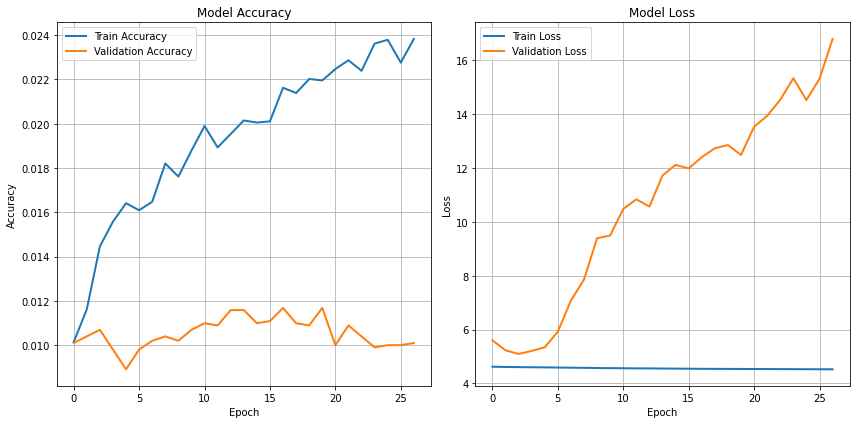

In [96]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()